# Machine Learning Essentials SS25 - Exercise Sheet 5

## Instructions
- `TODO`'s indicate where you need to complete the implementations.
- You may use external resources, but <b>write your own solutions</b>.
- Provide concise, but comprehensible comments to explain what your code does.
- Code that's unnecessarily extensive and/or not well commented will not be scored.

## Exercise 1

## Exercise 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# TODO: Import the stuff you need from torch and torchvision
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn

""""
If you stay in ML-related fields, you will likely be working on a server or cluster. If you do so,
always remember to set the number of CPU (or even GPU) threads you're using, as Jupyter notebooks or Python scripts 
might sometimes use all available threads by default, which will lead to unhappy colleagues or classmates that
also want to use some of the threads.
"""
# Example of limiting CPU threads:
# import os
# os.environ["OMP_NUM_THREADS"] = "15"
# os.environ["MKL_NUM_THREADS"] = "15"
# torch.set_num_threads(15) # If you only want to use PyTorch threads

'"\nIf you stay in ML-related fields, you will likely be working on a server or cluster. If you do so,\nalways remember to set the number of CPU (or even GPU) threads you\'re using, as Jupyter notebooks or Python scripts \nmight sometimes use all available threads by default, which will lead to unhappy colleagues or classmates that\nalso want to use some of the threads.\n'

### 2.1

In [3]:
# TODO: Define transformations
# Given statistics of training set:
mu_train = 0.286
std_train = 0.353
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mu_train, std=std_train),
])

# TODO: Load FashionMNIST train/testsets
train_dataset_full = datasets.FashionMNIST(
    root='./data',       
    train=True,          
    transform=transform, 
    download=True      # Download the dataset at the first run
)
test_dataset = datasets.FashionMNIST(
    root='./data',       
    train=False,         
    transform=transform, 
    download=True       
)

print(f"Full training dataset size: {len(train_dataset_full)}")
print(f"Test dataset size: {len(test_dataset)}")

Full training dataset size: 60000
Test dataset size: 10000


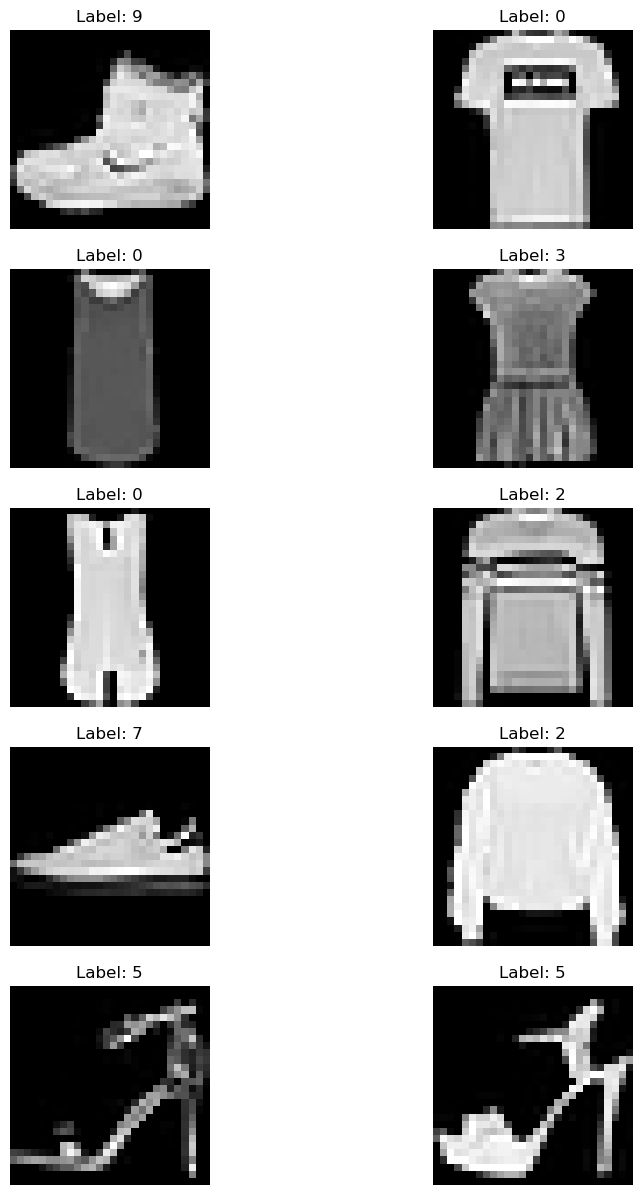

In [4]:
# TODO: Create 5x2 subplot grid w/ example image for each class
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
axes = axes.flatten()
for i in range(10):
    image, label = train_dataset_full[i]
    image_np = image.numpy().reshape(28, 28)
    axes[i].imshow(image_np, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')


In [5]:
# TODO: Create a validation set from the training set
train_set, val_set = torch.utils.data.random_split(train_dataset_full, [50000, 10000])
# print(f"Training set size: {len(train_set)}")
# print(f"Validation set size: {len(val_set)}")

### 2.2

In [6]:
# TODO: Define your model architecture: A class called MLP that inherits from nn.Module
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        input_size = 28 * 28
        hidden_size = 128
        output_size = 10
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

# TODO: Define appropriate loss
criterion = nn.CrossEntropyLoss()

### 2.3

In [7]:
BATCH_SIZE_DEFAULT = 256 # TODO: Set your default batch size. The capitalization is a convention used for global constants in Python

#TODO: Define DataLoaders for training, validation, and test sets
data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_DEFAULT, shuffle=True)
data_loader_val = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE_DEFAULT, shuffle=False)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_DEFAULT, shuffle=False)

In [8]:
def calculate_accuracy(outputs, labels):
    """
    Calculate accuracy given model outputs and true labels.
    """
    _, predicted = torch.max(outputs.data, 1) # Prediction = class with highest output probability
    total = labels.size(0) 
    correct = (predicted == labels).sum().item() #.item() converts a single-element tensor to a Python number ("scalar")
    return correct / total

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    # Device configuration: if available use GPU (needs CUDA installed and GPU with PyTorch support), otherwise CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Training on device: {device}")

    # TODO: Define training loop that for each epoch iterates over all mini-batches in the training set 
    # Record and return the training&validation loss and accuracy for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.
        train_correct = 0
        total = 0

        # train phase
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            output = model.forward(images)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            accuracy = calculate_accuracy(output, labels)
            train_correct += accuracy * labels.size(0)
            total += labels.size(0)

        # compute avg loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = train_correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
    
        # validation phase
        model.eval()

        # (context-manager that disables gradient calculation)
        with torch.no_grad():
            val_loss = 0.
            val_correct = 0
            val_total = 0

            for batch_idx, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                output = model.forward(images)
                loss = criterion(output, labels)
                val_loss += loss.item()
                accuracy = calculate_accuracy(output, labels)
                val_correct += accuracy * labels.size(0)
                val_total += labels.size(0)

        # ditto
        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    return train_losses, val_losses, train_accuracies, val_accuracies

### 2.4

In [9]:
# TODO: Define hyperparameter grid for tuning
hyperparameter_grid = {
    'learning_rate': [0.001],
    'batch_size': [64, 128, 256],
    'num_epochs': [5, 10]
}

# TODO: For each hyperparameter setting, instantiate model&optimizer, 
# train the model, and store the results for evaluation later
adam_results = []
for lr in hyperparameter_grid['learning_rate']:
    for batch_size in hyperparameter_grid['batch_size']:
        for num_epochs in hyperparameter_grid['num_epochs']:
            print(f"Training with learning rate={lr}, batch_size={batch_size}, num_epochs={num_epochs}")
            model = MLP()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
            val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

            train_losses, val_losses, train_accuracies, val_accuracies = train_model(
                model, criterion, optimizer, train_loader, val_loader, num_epochs
            )

            adam_results.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'num_epochs': num_epochs,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies
            })

Training with learning rate=0.001, batch_size=64, num_epochs=5
Training on device: cpu
Training with learning rate=0.001, batch_size=64, num_epochs=10
Training on device: cpu
Training with learning rate=0.001, batch_size=128, num_epochs=5
Training on device: cpu
Training with learning rate=0.001, batch_size=128, num_epochs=10
Training on device: cpu
Training with learning rate=0.001, batch_size=256, num_epochs=5
Training on device: cpu
Training with learning rate=0.001, batch_size=256, num_epochs=10
Training on device: cpu


KeyboardInterrupt: 

In [ ]:
# TODO: Define hyperparameter grid for tuning
hyperparameter_grid = {
    'learning_rate': [0.001],
    'batch_size': [64, 128, 256],
    'num_epochs': [5, 10]
}

# TODO: For each hyperparameter setting, instantiate model&optimizer, 
# train the model, and store the results for evaluation later
sgd_results = []
for lr in hyperparameter_grid['learning_rate']:
    for batch_size in hyperparameter_grid['batch_size']:
        for num_epochs in hyperparameter_grid['num_epochs']:
            print(f"Training with learning rate={lr}, batch_size={batch_size}, num_epochs={num_epochs}")
            model = MLP()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
            val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

            train_losses, val_losses, train_accuracies, val_accuracies = train_model(
                model, criterion, optimizer, train_loader, val_loader, num_epochs
            )

            sgd_results.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'num_epochs': num_epochs,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies
            })

Training with learning rate=0.001, batch_size=64, num_epochs=5
Training on device: cpu
Training with learning rate=0.001, batch_size=64, num_epochs=10
Training on device: cpu
Training with learning rate=0.001, batch_size=128, num_epochs=5
Training on device: cpu
Training with learning rate=0.001, batch_size=128, num_epochs=10
Training on device: cpu
Training with learning rate=0.001, batch_size=256, num_epochs=5
Training on device: cpu
Training with learning rate=0.001, batch_size=256, num_epochs=10
Training on device: cpu


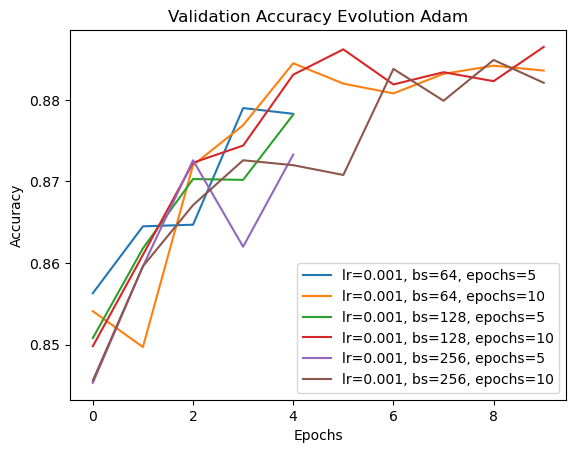

In [ ]:
# TODO: Plot evolution of validation accuracy for each hyperparameter setting
for result in adam_results:
    plt.plot(result['val_accuracies'], label=f"lr={result['learning_rate']}, bs={result['batch_size']}, epochs={result['num_epochs']}")
plt.title('Validation Accuracy Evolution Adam')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

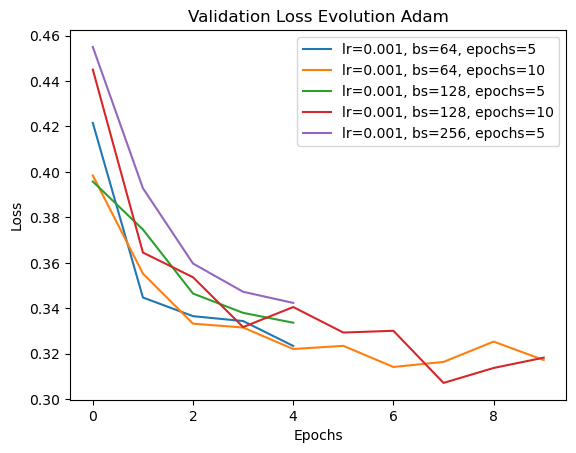

In [10]:
# TODO: Plot evolution of validation accuracy for each hyperparameter setting
for result in adam_results:
    plt.plot(result['val_losses'], label=f"lr={result['learning_rate']}, bs={result['batch_size']}, epochs={result['num_epochs']}")
plt.title('Validation Loss Evolution Adam')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# TODO: Plot evolution of validation accuracy for each hyperparameter setting
for result in sgd_results:
    plt.plot(result['val_accuracies'], label=f"lr={result['learning_rate']}, bs={result['batch_size']}, epochs={result['num_epochs']}")
plt.title('Validation Accuracy Evolution SGD')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'sgd_results' is not defined

In [12]:
# TODO: Plot evolution of validation accuracy for each hyperparameter setting
for result in sgd_results:
    plt.plot(result['val_losses'], label=f"lr={result['learning_rate']}, bs={result['batch_size']}, epochs={result['num_epochs']}")
plt.title('Validation Loss Evolution SGD')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'sgd_results' is not defined

**TODO**: Justify which batch size and learning rate combination you will go with.

### 2.4

In [13]:
# TODO: Train model w/ best hyperparameters for SGD and compare to default Adam optimizer
model_adam = MLP()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(model_adam.parameters())

adam_results_best_hyper_param = []
sgd_results_best_hyper_param = []

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_adam, criterion, optimizer, train_loader, val_loader, 30
)

adam_results_best_hyper_param.append({
    'learning_rate': lr,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
})


Training on device: cpu


In [14]:
model_sgd = MLP()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)
optimizer = torch.optim.SGD(model_sgd.parameters(), lr=lr)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_sgd, criterion, optimizer, train_loader, val_loader, 30
)

sgd_results_best_hyper_param.append({
    'learning_rate': lr,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
})

Training on device: cpu


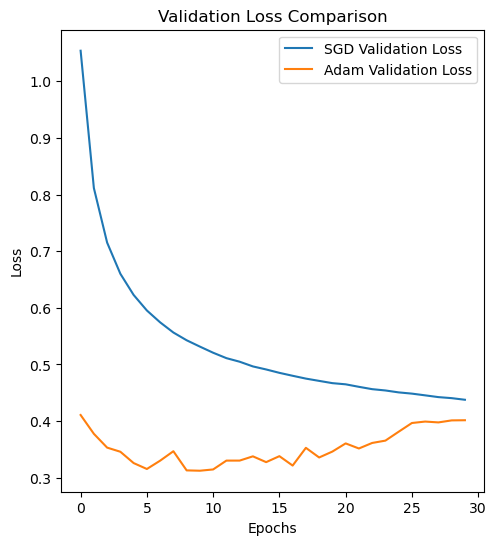

In [15]:
# TODO: Plot "learning curves" of the best SGD model and the Adam model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(sgd_results_best_hyper_param[-1]['val_losses'], label='SGD Validation Loss')
plt.plot(adam_results_best_hyper_param[-1]['val_losses'], label='Adam Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

**TODO**: Based on plots, compare (mini-batch) SGD and Adam, select overall best Model

In [17]:
#TODO: Evaluate the best model on the test set, print the test/train/validation accuracy
print("Evaluating on test set...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_correct += (outputs.argmax(dim=1) == labels).sum().item()
        test_total += labels.size(0)
test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Evaluating on test set...
Test Accuracy: 0.8329


**TODO**: Briefly discuss your results.


We set the batch size as 64 and run 30 epoches for SGD and Adam respectively. The loss curve of SGD keeps going down whilst the curve of Adam oscillates. The lowest loss (ca. 0.3) for Adam is observed at epoch=10. Thereafter, the loss has an increasing tendency, probably because of overfitting. Besides, the loss of SGD is almost everywhere bigger than that of Adam when epoch lies in the interval between 0 and 30$. However, we can expect it to outperform Adam, if this tendency goes on.